### IMPORTS

In [28]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### HYPER PARAMS

In [29]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#### DATASET

In [30]:
train_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('./data/', train=True, download=True,
	                           transform=torchvision.transforms.Compose([
		                           torchvision.transforms.ToTensor(),
		                           torchvision.transforms.Normalize(
			                           (0.1307,), (0.3081,))
	                           ])),
	batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
	torchvision.datasets.MNIST('./data/', train=False, download=True,
	                           transform=torchvision.transforms.Compose([
		                           torchvision.transforms.ToTensor(),
		                           torchvision.transforms.Normalize(
			                           (0.1307,), (0.3081,))
	                           ])),
	batch_size=batch_size_test, shuffle=True)

#### Peeking the DATASET

In [31]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

#### PLOTTING SOME DATA FOR VISUALIZATION

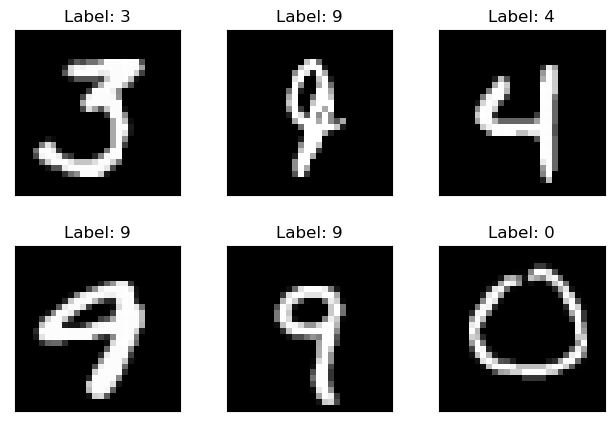

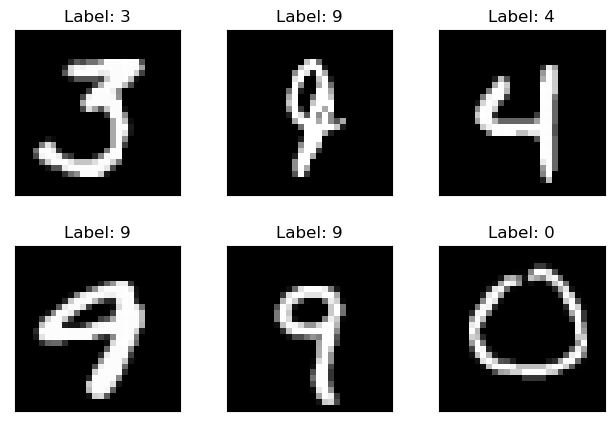

In [32]:
fig = plt.figure()
for i in range(6):
	plt.subplot(2,3,i+1)
	plt.tight_layout()
	plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
	plt.title("Label: {}".format(example_targets[i]))
	plt.xticks([])
	plt.yticks([])
fig

### MODEL

In [33]:
class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(320, 50)
		self.fc2 = nn.Linear(50, 10)

	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 320)
		x = F.relu(self.fc1(x))
		x = F.dropout(x, training=self.training)
		x = self.fc2(x)
		return F.log_softmax(x, 1)

In [34]:
# init the model
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

#### SOME LOGGING VARIABLES

In [35]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### TRAINING AND TESTING METHOD

In [36]:
def train(epoch):
	network.train()
	for batch_idx, (data, target) in enumerate(train_loader):
		optimizer.zero_grad()
		output = network(data)
		loss = F.nll_loss(output, target)
		loss.backward()
		optimizer.step()
		if batch_idx % log_interval == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				       100. * batch_idx / len(train_loader), loss.item()))
			train_losses.append(loss.item())
			train_counter.append(
				(batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
			torch.save(network.state_dict(), './checkpoints/MNIST-model.pth')
			torch.save(optimizer.state_dict(), './checkpoints/MNIST-optimizer.pth')


def test():
	network.eval()
	test_loss = 0
	correct = 0
	with torch.no_grad():
		for data, target in test_loader:
			output = network(data)
			test_loss += F.nll_loss(output, target, size_average=False).item()
			pred = output.data.max(1, keepdim=True)[1]
			correct += pred.eq(target.data.view_as(pred)).sum()
	test_loss /= len(test_loader.dataset)
	test_losses.append(test_loss)
	print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
		test_loss, correct, len(test_loader.dataset),
		100. * correct / len(test_loader.dataset)))

### MODEL TRAINING

In [37]:
test()
for epoch in range(1, n_epochs + 1):
	train(epoch)
	test()

/usr/local/anaconda3/envs/dl-env/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [4096/60000 (7%)]	Loss: 2.214404
Train Epoch: 1 [8192/60000 (14%)]	Loss: 1.548591
Train Epoch: 1 [12288/60000 (20%)]	Loss: 1.129882
Train Epoch: 1 [16384/60000 (27%)]	Loss: 1.073255
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.582403
Train Epoch: 1 [24576/60000 (41%)]	Loss: 0.983538
Train Epoch: 1 [28672/60000 (48%)]	Loss: 0.544155
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.687503
Train Epoch: 1 [36864/60000 (61%)]	Loss: 0.730152
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.337059
Train Epoch: 1 [45056/60000 (75%)]	Loss: 0.420433
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.834110
Train Epoch: 1 [53248/60000 (89%)]	Loss: 0.542384
Train Epoch: 1 [57344/60000 (96%)]	Loss: 0.466105

Test set: Avg. loss: 0.1862, Accuracy: 9440/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.447946
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.211271
Train Epoch: 2 [8192/60000 (14%)]	Loss: 0.462496
Tr

#### EVALUATION PLOTS

Text(0, 0.5, 'negative log likelihood loss')

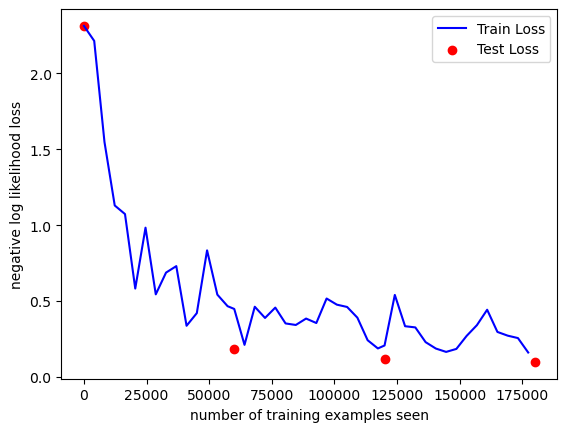

In [39]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# fig

## MORE EPOCH NEEDED